In [1]:
# Olufunke Olaleye

# import Libraries
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import math
import datetime
import time


# from sqlalchemy import create_engine, inspect, func
from sqlalchemy import create_engine

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

# Introduction:

As an emerging investor, I am looking to invest in the stock market at a precise time. I am attempting to time the market in search of opportunities to buy low and sell high. However, there are many stocks to choose from. I need to filter through the stock to find the group of performing stocks at a specific time of the year (i.e. 31 of december). In this project, I will attempt to use the K-means clustering algorithm to identify some performing stocks.

# K-means Clustering


## Data Transformation
I am using the last monthend of the last 5 years 2014 -2018, to see how stock performed by the end of each year.

In [2]:
database_name = "../data/CompanyData.sqlite"
engine = create_engine(f"sqlite:///{database_name}", echo=False)

In [3]:
# Load the data from database
master_df = pd.read_sql_query("SELECT * FROM MasterData", engine)
master_df = master_df.dropna()
master_df.head()

,monthend_date,ticker,price,wealth_index,end_wealth_index,total_return,cash,st_debt,lt_debt,equity,...,market_cap,net_debt,net_debt_capital,enterprise_value,ev_revenue,revenue_ev,ev_ebit,ebit_ev,name,sector
0,2014-12-31,A,40.94,39.0850,36.1469,-7.517206,2.218000e+09,0.0,1.663000e+09,5.301000e+09,...,1.362185e+10,-555000000.0,-11.694058,1.306685e+10,3.227978,0.309791,31.185810,0.032066,Agilent Technologies Inc,Health Care
1,2015-01-31,A,37.77,36.1469,40.3961,11.755365,2.218000e+09,0.0,1.663000e+09,5.301000e+09,...,1.256711e+10,-555000000.0,-11.694058,1.201211e+10,2.967418,0.336993,28.668518,0.034881,Agilent Technologies Inc,Health Care
2,2015-02-28,A,42.21,40.3961,39.8624,-1.321167,2.218000e+09,0.0,1.663000e+09,5.301000e+09,...,1.404442e+10,-555000000.0,-11.694058,1.348942e+10,3.332366,0.300087,32.194315,0.031061,Agilent Technologies Inc,Health Care
3,2015-03-31,A,41.55,39.8624,39.6897,-0.433240,2.118000e+09,0.0,1.658000e+09,4.237000e+09,...,1.386108e+10,-460000000.0,-12.178978,1.340108e+10,3.295888,0.303408,32.685561,0.030595,Agilent Technologies Inc,Health Care
4,2015-04-30,A,41.37,39.6897,39.5170,-0.435125,2.118000e+09,0.0,1.658000e+09,4.237000e+09,...,1.380103e+10,-460000000.0,-12.178978,1.334103e+10,3.281120,0.304774,32.539102,0.030732,Agilent Technologies Inc,Health Care


In [4]:
# Query databse for specific data in 2014-12-31

df_2014_m = pd.read_sql_query('SELECT monthend_date, ticker, earnings_yield, book_yield, net_debt_capital, revenue_ev, ebit_ev, total_return, sector FROM MasterData WHERE monthend_date="2014-12-31" AND NOT earnings_yield = "0" ', engine)
df_2014_m = df_2014_m.dropna()
df_2014_m.head()

,monthend_date,ticker,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector
0,2014-12-31,A,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206,Health Care
1,2014-12-31,AAL,-7.626329,-131.855725,76.195949,3.282663,0.288586,-8.484063,Industrials
2,2014-12-31,AAP,3.911351,16.552086,46.088087,0.678925,0.059980,-0.175748,Consumer Discretionary
3,2014-12-31,AAPL,5.843450,16.599889,16.128814,0.263612,0.075715,6.142435,Information Technology
4,2014-12-31,ABBV,3.514670,4.417194,60.360130,0.174810,0.047768,-7.085789,Health Care


In [5]:
df_2014 = df_2014_m.copy()
df_2014 = df_2014.drop(columns=["monthend_date", "ticker",])

In [6]:
df_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 464
Data columns (total 7 columns):
earnings_yield      463 non-null float64
book_yield          463 non-null float64
net_debt_capital    463 non-null float64
revenue_ev          463 non-null float64
ebit_ev             463 non-null float64
total_return        463 non-null float64
sector              463 non-null object
dtypes: float64(6), object(1)
memory usage: 28.9+ KB


In [7]:
df_2014dummy = pd.get_dummies(df_2014)
df_2014dummy.head()

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities
0,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206,0,0,0,0,0,1,0,0,0,0,0
1,-7.626329,-131.855725,76.195949,3.282663,0.288586,-8.484063,0,0,0,0,0,0,1,0,0,0,0
2,3.911351,16.552086,46.088087,0.678925,0.059980,-0.175748,0,1,0,0,0,0,0,0,0,0,0
3,5.843450,16.599889,16.128814,0.263612,0.075715,6.142435,0,0,0,0,0,0,0,1,0,0,0
4,3.514670,4.417194,60.360130,0.174810,0.047768,-7.085789,0,0,0,0,0,1,0,0,0,0,0


In [8]:
# Retrieve the statistic for 2014-12-31
df_2014dummy.describe()

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities
count,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000
mean,4.608727,35.078201,23.970915,0.494227,0.053735,-1.723477,0.045356,0.125270,0.062635,0.056156,0.138229,0.129590,0.140389,0.129590,0.045356,0.069114,0.058315
std,3.254615,29.535471,102.410749,0.610192,0.037993,7.291320,0.208310,0.331383,0.242567,0.230471,0.345513,0.336215,0.347766,0.336215,0.208310,0.253923,0.234592
min,-9.972426,-131.855725,-1815.391598,-1.499539,-0.108998,-27.049938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.141542,16.281141,9.798882,0.199438,0.031083,-6.401576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.439989,28.517004,32.929205,0.330965,0.056122,-2.161696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.882592,47.808729,52.642627,0.568449,0.072858,2.762537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,23.378736,189.262121,289.863198,5.798513,0.288586,35.943248,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# Data Processing
# Extract the criteria for the scaling
df_2014 = df_2014dummy.iloc[ : , 0:6]
df_2014.head()

,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return
0,3.957010,38.915406,-11.694058,0.309791,0.032066,-7.517206
1,-7.626329,-131.855725,76.195949,3.282663,0.288586,-8.484063
2,3.911351,16.552086,46.088087,0.678925,0.059980,-0.175748
3,5.843450,16.599889,16.128814,0.263612,0.075715,6.142435
4,3.514670,4.417194,60.360130,0.174810,0.047768,-7.085789


In [11]:
# standardized the data
scaler = StandardScaler()

scaled_2014 = scaler.fit_transform(df_2014)

# statistics of scaled data


scaled_data2014 = pd.DataFrame(scaled_2014)

In [12]:
# Add the sectors back to the data before training the data

In [14]:
dummy_sector = df_2014dummy.iloc[ : , 6:]
#dummy_sector = np.nan_to_num(dummy_sector)
dummy_sector.head()

,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities
0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0


In [15]:
dummy_sector = dummy_sector.rename(columns = {'sector_Communication Services':6, 'sector_Consumer Discretionary':7, 'sector_Consumer Staples':8, 'sector_Energy': 9, 'sector_Financials': 10, 'sector_Health Care': 11, 'sector_Industrials': 12, 'sector_Information Technology':13, 'sector_Materials':14,  'sector_Real Estate': 15, 'sector_Utilities':16 })
dummy_sector.head()

,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0


In [16]:
train_data = pd.concat([scaled_data2014, dummy_sector ], axis=1)
train_data.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.200460,0.130059,-0.348631,-0.302585,-0.570971,-0.795466,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-3.763360,-5.658095,0.510508,4.574709,6.188079,-0.928213,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.214505,-0.627928,0.216199,0.303015,0.164540,0.212500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.379786,-0.626308,-0.076658,-0.378348,0.579152,1.079972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.336519,-1.039231,0.355710,-0.524035,-0.157239,-0.736233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
train_data = np.nan_to_num(train_data)


In [18]:
# Train the model

In [19]:
# defining the kmeans function with initialization as k-means++

kmeans_2014 = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data

kmeans_2014.fit(train_data)

# inertia on the fitted data



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Text(0, 0.5, 'Inertia')

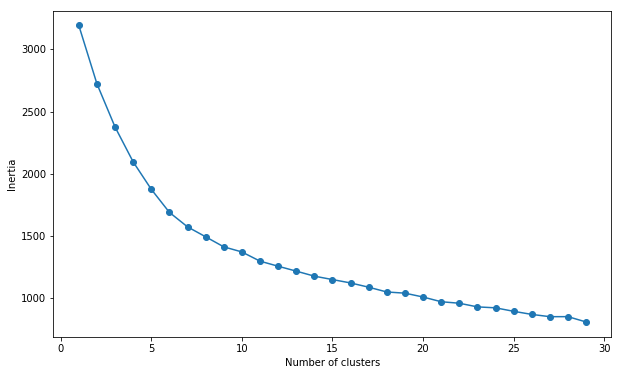

In [20]:
# Find the elbow
# Draw elbow plot and figure out the optimal value of k
# fitting multiple k-means algorithms and storing the values in an empty list

SSE = []

for cluster in range(1,30):

    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')

    kmeans.fit(train_data)

    SSE.append(kmeans.inertia_)


# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,30), 'SSE':SSE})

plt.figure(figsize=(10,6))

plt.plot(frame['Cluster'], frame['SSE'], marker='o')

plt.xlabel('Number of clusters')

plt.ylabel('Inertia')

In [21]:
# k means using 7 clusters and k-means++ initialization

kmeans = KMeans(n_clusters=8)

kmeans.fit(train_data)

# labels = kmeans.labels_
predicted_clusters = kmeans.predict(train_data)


In [22]:
# Print the cluster centers and cluster labels
centers = kmeans.cluster_centers_
#centers

In [23]:
predicted_clusters_2014 = pd.DataFrame(predicted_clusters)
predicted_clusters_2014.head()

,0
0,4
1,1
2,6
3,0
4,4


In [24]:
monthend_date = df_2014_m['monthend_date']
sector = df_2014_m['sector']
ticker = df_2014_m['ticker']
#total_return = df_2014_m['total_return']

#train_data2014 = train_data.iloc[ : , 0:6]
frame_2014 = pd.DataFrame(train_data)

frame_2014['cluster'] = predicted_clusters
frame_2014['monthend_date'] = monthend_date
frame_2014['ticker'] = ticker
#frame_2014['total_return'] = total_return
frame_2014['sector'] = sector

frame_2014 = frame_2014.drop(columns=[6, 7,8,9,10,11,12,13,14,15,16])

frame_2014.head()

,0,1,2,3,4,5,cluster,monthend_date,ticker,sector
0,-0.200460,0.130059,-0.348631,-0.302585,-0.570971,-0.795466,4,2014-12-31,A,Health Care
1,-3.763360,-5.658095,0.510508,4.574709,6.188079,-0.928213,1,2014-12-31,AAL,Industrials
2,-0.214505,-0.627928,0.216199,0.303015,0.164540,0.212500,6,2014-12-31,AAP,Consumer Discretionary
3,0.379786,-0.626308,-0.076658,-0.378348,0.579152,1.079972,0,2014-12-31,AAPL,Information Technology
4,-0.336519,-1.039231,0.355710,-0.524035,-0.157239,-0.736233,4,2014-12-31,ABBV,Health Care


In [25]:
# Rename the new dataframe columns accordingly

frame_2014 = frame_2014.rename(columns = {0:'earnings_yield', 1:'book_yield', 2:'net_debt_capital', 3:'revenue_ev',  4:'ebit_ev', 5:'total_return' })


In [26]:
# Re-arrange columns of dataframe
# 5:'Communication Services', 6:'Consumer Discretionary', 8:'Consumer Staples', 9:'Energy',  10:'Financials', 11:'Health Care', 12:'Industrials', 13:'Information Technology', 14:'Materials',  15:'Real Estate', 16:'Utilities'
frame_2014 = frame_2014[['monthend_date', 'earnings_yield', 'book_yield', 'net_debt_capital', 'revenue_ev','ebit_ev', 'total_return', 'cluster','ticker', 'sector']]
frame_2014.head(10) 

,monthend_date,earnings_yield,book_yield,net_debt_capital,revenue_ev,ebit_ev,total_return,cluster,ticker,sector
0,2014-12-31,-0.200460,0.130059,-0.348631,-0.302585,-0.570971,-0.795466,4,A,Health Care
1,2014-12-31,-3.763360,-5.658095,0.510508,4.574709,6.188079,-0.928213,1,AAL,Industrials
2,2014-12-31,-0.214505,-0.627928,0.216199,0.303015,0.164540,0.212500,6,AAP,Consumer Discretionary
3,2014-12-31,0.379786,-0.626308,-0.076658,-0.378348,0.579152,1.079972,0,AAPL,Information Technology
4,2014-12-31,-0.336519,-1.039231,0.355710,-0.524035,-0.157239,-0.736233,4,ABBV,Health Care
5,2014-12-31,-1.021847,-0.864347,-0.149007,8.702213,-0.416522,0.981293,1,ABC,Health Care
6,2014-12-31,-1.215549,-0.788313,-0.342446,-0.590184,-1.219962,5.171556,5,ABMD,Health Care
7,2014-12-31,-0.549894,-0.068757,-0.068139,-0.369180,-0.561348,0.229590,4,ABT,Health Care
8,2014-12-31,0.139121,-0.845798,-5.947436,0.200204,0.774919,-0.575068,4,ACN,Information Technology
9,2014-12-31,-0.320644,-0.261231,-0.175694,-0.545094,-0.294843,-0.606637,4,ADI,Information Technology


In [27]:

cluster2014return = frame_2014[['cluster', 'ticker', 'total_return',  'sector']]
cluster2014return.set_index("cluster")
cluster2014return.to_csv('file/cluster2014return.csv')

In [30]:
# The number of tickers in each cluster
cluster_counts = frame_2014['cluster'].value_counts()
cluster_counts

4    122
6    121
0     88
5     53
2     33
7     30
1     17
3      1
Name: cluster, dtype: int64

In [32]:
# Extract each ticker and sector in each cluster
flag=True

for i in range(0,11):
   
    cluster_group = frame_2014.loc[frame_2014["cluster"] ==i]["ticker"]

    cluster_sector = frame_2014.loc[frame_2014["cluster"] ==i]["sector"]
   
    cluster_tickergroup=pd.concat([cluster_group, cluster_sector], axis=1)
    cluster_tickergroup["cluster"]=i
    if flag==True:
        clusterlist=cluster_tickergroup
        flag=False
    else:
        clusterlist=pd.concat([clusterlist, cluster_tickergroup])
clusterlist=clusterlist.set_index("cluster")
clusterlist.head()

,ticker,sector
cluster,,
0,AAPL,Information Technology
0,AEE,Utilities
0,AEP,Utilities
0,AIV,Real Estate
0,ALK,Industrials
